In [ ]:
import pandas as pd
import numpy as np

import os, sys

sys.path.insert(0, '/nas/longleaf/home/smerrill/ensemble_pruning/')

from datetime import date
import random

import pickle

from sklearn.tree import DecisionTreeClassifier
from joblib import dump, load

from scipy.stats import wasserstein_distance

import numpy as np
from scipy.spatial.distance import cosine, euclidean
import argparse

from utils import *
from fitness_functions import *
from voting_classifier import voting_classifier

import matplotlib.pyplot as plt
import tqdm

# This notebook is used to Test New Fitness Functions

### 1.  Define Arguments

In [18]:
dataset_path = r'/nas/longleaf/home/smerrill/evolution/datasets'
dataset = 'heloc_tf'
model_pool_path = f'/proj/mcavoy_lab/data/evo_models/exps/cheating_fitness_0802_EOD/{dataset}/0/models'
ensemble_size = 100
ntrls = 100
seed = 1

In [19]:
# seeds
np.random.seed(seed)
random.seed(seed)
rng = np.random.RandomState(seed)

# datasets
x_train, y_train, x_val_id, y_val_id, x_val_ood, y_val_ood = get_dataset(dataset_path, dataset)
num_features = x_train.shape[1]

print("Loding Model Pool")
all_models = os.listdir(model_pool_path)[:100]
model_pool = [load_model(model_pool_path + f'/{x}') for x in all_models]


# store these in model pool as attributes
model_pool_clf = voting_classifier(model_pool, num_features)

model_pool_train_pred_probs = np.array(model_pool_clf.get_model_pred_probs(x_train))
model_pool_val_pred_probs = np.array(model_pool_clf.get_model_pred_probs(x_val_id))
model_pool_ood_pred_probs = np.array(model_pool_clf.get_model_pred_probs(x_val_ood))

model_pool_clf.val_ood_pred_probs = model_pool_ood_pred_probs
model_pool_clf.train_pred_probs = model_pool_train_pred_probs
model_pool_clf.val_pred_probs = model_pool_val_pred_probs

AUCTHRESHS = np.array([0.1, 0.2, 0.3, 0.4, 1. ])
model_pool_preds = model_pool_clf.predict(x_val_ood)
model_pool_pred_probs = model_pool_clf.predict_proba(x_val_ood)
mp_precision, mp_recall, mp_auc = get_precision_recall_auc(model_pool_pred_probs, y_val_ood, AUCTHRESHS)

Loding Model Pool


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### 2. Make a new fitness function test
- This fitness function clusters data into 100 bins
- Then identifies the 10 most distant clusters contingent on those clusters having at least 10 samples
- Then it computes the average,min,max accuracy and auc of the ensemble on these potentially distinct environments
- Fitness function can then be any combination of these metrics (min/max/avg) X (auc/acc)

In [20]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def get_cluster_acc_fitness(model_pool_clf, indices):
    cluster_acc_train = []
    cluster_acc_val = []

    for i in range(len(cluster_array_train)):
        class1_prob_train = model_pool_clf.train_pred_probs[indices][:,cluster_array_train[i]].argmax(axis=-1).mean(axis=0)
        class1_prob_val = model_pool_clf.val_pred_probs[indices][:,cluster_array_val[i]].argmax(axis=-1).mean(axis=0)

        sampled_preds_train = np.where(class1_prob_train>0.5, 1, 0)
        sampled_preds_val = np.where(class1_prob_val>0.5, 1, 0)

        train_acc = np.mean(y_train[cluster_array_train[i]] == sampled_preds_train)
        val_acc = np.mean(y_val_id[cluster_array_val[i]] == sampled_preds_val)

        #cluster_acc_train.append(train_acc)
        #cluster_acc_val.append(val_acc)
        cluster_acc_train.append(roc_auc_score(y_train[cluster_array_train[i]], class1_prob_train))
        try:
            cluster_acc_val.append(roc_auc_score(y_val_id[cluster_array_val[i]], class1_prob_val))
        except:
            continue
    cluster_acc_val = np.array(cluster_acc_val)
    cluster_acc_val = cluster_acc_val[ ~np.isnan(cluster_acc_val)]
    return np.array(cluster_acc_train), cluster_acc_val

In [21]:
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(x_train)

val_labels = kmeans.predict(x_val_id)

cluster_array_train =[]
cluster_array_val =[]

for cluster_idx in range(num_clusters):
    cluster_array_train.append(np.where(kmeans.labels_==cluster_idx)[0])
    cluster_array_val.append(np.where(val_labels==cluster_idx)[0])

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


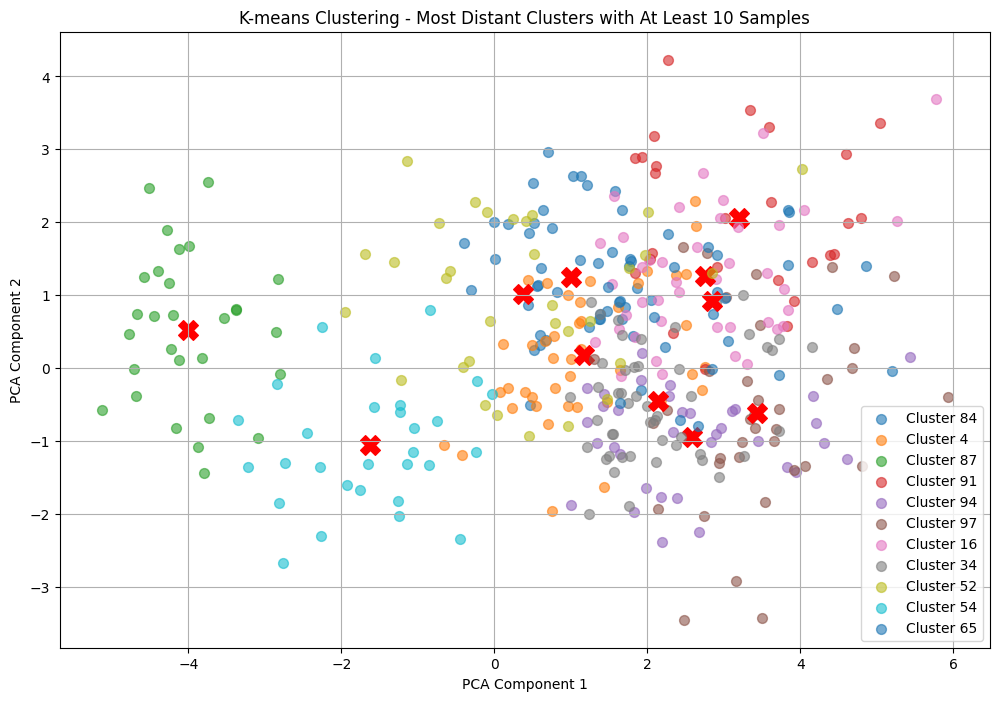

In [22]:
# Perform k-means clustering with 100 clusters
k = 100
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(x_train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Filter clusters with at least 10 samples
unique_labels, counts = np.unique(labels, return_counts=True)
valid_labels = unique_labels[counts >= 25]

# If no valid clusters are found, raise an exception
if len(valid_labels) < 5:
    raise ValueError("Not enough clusters with at least 10 samples to select 10 most distant clusters.")

# Keep only the clusters with at least 10 samples
filtered_centroids = centroids[valid_labels]
filtered_labels = np.isin(labels, valid_labels)

# Calculate pairwise distances between the valid cluster centroids
distances = cdist(filtered_centroids, filtered_centroids, metric='euclidean')

# Get indices of the 10 most distant clusters
np.fill_diagonal(distances, 0)  # Ignore self-distances
most_distant_indices = np.unravel_index(np.argsort(distances, axis=None)[-20:], distances.shape)
most_distant_clusters = set(most_distant_indices[0]).union(set(most_distant_indices[1]))

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train)
centroids_pca = pca.transform(centroids)

# Map filtered centroids to PCA space
filtered_centroids_pca = pca.transform(filtered_centroids)

# Plotting
plt.figure(figsize=(12, 8))

# Scatter plot of the data points, colored by cluster
for cluster in most_distant_clusters:
    mask = labels == valid_labels[cluster]
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {valid_labels[cluster]}', s=50, alpha=0.6)
    plt.scatter(filtered_centroids_pca[cluster, 0], filtered_centroids_pca[cluster, 1], c='red', s=200, marker='X')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering - Most Distant Clusters with At Least 10 Samples')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
cluster_array_train =[]
cluster_array_val =[]

for cluster_idx in set(most_distant_indices[0]):
    cluster_array_train.append(np.where(kmeans.labels_==cluster_idx)[0])
    cluster_array_val.append(np.where(val_labels==cluster_idx)[0])

### 3.  Running Serach and computing Fitness Scores

In [24]:
####################################################
#################### Starting Script ##################
####################################################
print("Starting SEARCH Script")

precisions_df = pd.DataFrame()
recalls_df = pd.DataFrame()
aucs_df = pd.DataFrame()
results_df=pd.DataFrame()

for trial in tqdm.tqdm(range(ntrls)):
#    print(f"Starting Trial {trial}")

    indices = np.random.choice(model_pool_clf.ensemble.shape[0], size=ensemble_size, replace=True)

    tmp = {'generation':trial,
           'ensemble_files':','.join(str(x) for x in indices)}

    ood_preds, ood_pred_probs = get_ensemble_preds_from_models(model_pool_clf.val_ood_pred_probs[indices])
    train_acc_fitness, val_acc_fitness = get_cluster_acc_fitness(model_pool_clf, indices)
    tmp['train_acc_mean'] = train_acc_fitness.mean()
    tmp['train_acc_std'] = train_acc_fitness.std()
    tmp['train_acc_mean_std'] = tmp['train_acc_mean']/tmp['train_acc_std']

    tmp['train_acc_min'] = train_acc_fitness.min()
    #tmp['val_acc_mean'] = val_acc_fitness.mean()
    #tmp['val_acc_min'] = val_acc_fitness.min()
    
    
    # save dfs
    precision, recall, auc = get_precision_recall_auc(ood_pred_probs, y_val_ood, AUCTHRESHS)
    recalls_df = pd.concat([recalls_df, pd.DataFrame(recall)], axis=1)
    precisions_df = pd.concat([precisions_df, pd.DataFrame(precision)], axis=1)
    aucs_df = pd.concat([aucs_df, pd.DataFrame(auc)], axis=1)
        
    results_df = pd.concat([results_df, pd.DataFrame([tmp])])

Starting SEARCH Script


  0%|          | 0/100 [00:00<?, ?it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, ax

  3%|▎         | 3/100 [00:00<00:04, 23.35it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._me

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

  9%|▉         | 9/100 [00:00<00:03, 24.25it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._me

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

 15%|█▌        | 15/100 [00:00<00:03, 24.53it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 18%|█▊        | 18/100 [00:00<00:03, 24.47it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 21%|██        | 21/100 [00:00<00:03, 24.54it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 24%|██▍       | 24/100 [00:00<00:03, 24.72it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 27%|██▋       | 27/100 [00:01<00:02, 24.72it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 30%|███       | 30/100 [00:01<00:02, 24.73it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 33%|███▎      | 33/100 [00:01<00:02, 24.73it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 36%|███▌      | 36/100 [00:01<00:02, 24.64it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

 51%|█████     | 51/100 [00:02<00:02, 24.45it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 69%|██████▉   | 69/100 [00:02<00:01, 24.19it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhe

 84%|████████▍ | 84/100 [00:03<00:00, 24.43it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 87%|████████▋ | 87/100 [00:03<00:00, 24.42it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 90%|█████████ | 90/100 [00:03<00:00, 24.63it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 93%|█████████▎| 93/100 [00:03<00:00, 24.63it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 96%|█████████▌| 96/100 [00:03<00:00, 24.61it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

 99%|█████████▉| 99/100 [00:04<00:00, 24.58it/s]/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._m

### 4.  Get Ensembles with best fitness

In [25]:
results_df = results_df.reset_index(drop=True)
best_fitness_index = {i+1:index for i,index in enumerate(results_df.nlargest(3, 'train_acc_min').index)}

### 5.  Plot Result 

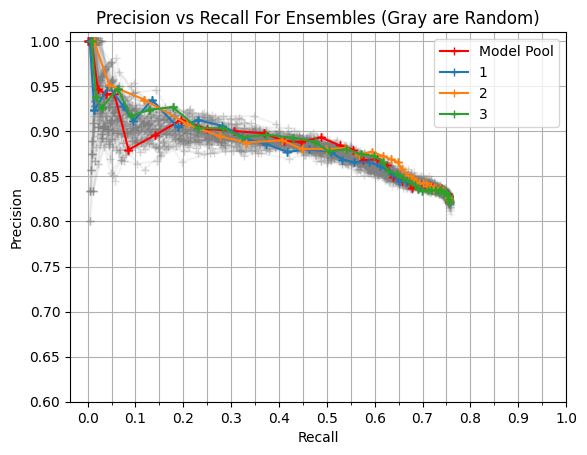

In [26]:
# Plotting all Random's
for i in range(ntrls):
    recall = recalls_df.iloc[:,i].values
    precision = precisions_df.iloc[:,i].values
    
    plt.plot(recall, precision, marker='+', c='gray', alpha=0.1)

    
# plot full
plt.plot(mp_recall,
         mp_precision,
         marker='+',
         c='red',
         label='Model Pool')


# plot the best fitness found for each fitness function
for key, value in best_fitness_index.items():
    plt.plot(recalls_df.iloc[:,value].values,
         precisions_df.iloc[:,value].values,
         marker='+',
         label=key)

plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(0.6, 1.01, step=0.05))
plt.ylim(0.6, 1.01)
plt.grid(True, which='both')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall For Ensembles (Gray are Random)')
plt.legend(loc='best')